# NFL Game Prediction Model - Random Forest Feature Selection

This notebook uses **Random Forest** to identify the most predictive features, then trains a Logistic Regression model using only those top features.

All features end with `_prior` suffix and are calculated from games **before** the target game (no data leakage).

In [1]:
# Import libraries
import nflreadpy as nfl


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# ============================================================================
# STEP 1: Load NFL datasets
# ============================================================================
print("Loading NFL data...")
team_stats = nfl.load_team_stats([2021, 2022, 2023, 2024, 2025]).to_pandas()
schedules = nfl.load_schedules([2021, 2022, 2023, 2024, 2025]).to_pandas()
player_stats = nfl.load_player_stats([2021, 2022, 2023, 2024, 2025]).to_pandas()
ff_rankings = nfl.load_ff_rankings().to_pandas()
print("✓ Data loaded successfully")

print(schedules.head())

Loading NFL data...
✓ Data loaded successfully
           game_id  season game_type  week     gameday   weekday gametime  \
0   2021_01_DAL_TB    2021       REG     1  2021-09-09  Thursday    20:20   
1  2021_01_PHI_ATL    2021       REG     1  2021-09-12    Sunday    13:00   
2  2021_01_PIT_BUF    2021       REG     1  2021-09-12    Sunday    13:00   
3  2021_01_NYJ_CAR    2021       REG     1  2021-09-12    Sunday    13:00   
4  2021_01_MIN_CIN    2021       REG     1  2021-09-12    Sunday    13:00   

  away_team  away_score home_team  ...  wind  away_qb_id  home_qb_id  \
0       DAL        29.0        TB  ...   9.0  00-0033077  00-0019596   
1       PHI        32.0       ATL  ...   NaN  00-0036389  00-0026143   
2       PIT        23.0       BUF  ...  17.0  00-0022924  00-0034857   
3       NYJ        14.0       CAR  ...   0.0  00-0037013  00-0034869   
4       MIN        24.0       CIN  ...  15.0  00-0029604  00-0036442   

         away_qb_name  home_qb_name     away_coach      h

In [3]:
# ============================================================================
# STEP 2: Create PRIOR GAME features (no data leakage!)
# ============================================================================
# These features only use data from games BEFORE the current game

print("\nBuilding prior features...")

# Start with completed regular season games
completed_games = schedules[schedules['game_type'] == 'REG'].dropna(subset=['home_score', 'away_score']).copy()

# Prepare game-level stats
game_stats = team_stats[['season', 'week', 'team', 
                          'passing_yards', 'rushing_yards', 'passing_interceptions',
                          'def_interceptions', 'sacks_suffered', 'rushing_fumbles_lost',
                          'receiving_fumbles_lost', 'sack_fumbles_lost', 'def_fumbles',
                          'penalty_yards', 'attempts', 'carries']].copy()

# Calculate derived metrics at game level
game_stats['total_fumbles_lost'] = (
    game_stats['rushing_fumbles_lost'] + 
    game_stats['receiving_fumbles_lost'] + 
    game_stats['sack_fumbles_lost']
)

game_stats['total_plays'] = game_stats['attempts'] + game_stats['carries']
game_stats['total_yards'] = game_stats['passing_yards'] + game_stats['rushing_yards']
game_stats['yards_per_play'] = game_stats['total_yards'] / game_stats['total_plays'].replace(0, 1)

game_stats['turnovers_forced'] = game_stats['def_interceptions'] + game_stats['def_fumbles']
game_stats['turnovers_committed'] = game_stats['passing_interceptions'] + game_stats['total_fumbles_lost']
game_stats['turnover_diff'] = game_stats['turnovers_forced'] - game_stats['turnovers_committed']

# Sort by season and week to ensure temporal ordering
game_stats = game_stats.sort_values(['season', 'week']).reset_index(drop=True)
completed_games = completed_games.sort_values(['season', 'week']).reset_index(drop=True)

# ============================================================================
# Calculate RECENCY-WEIGHTED PRIOR stats for each team at each game
# ============================================================================

def calculate_prior_features(df, team_col, season_col='season', week_col='week'):
    """
    Calculate statistics from recent prior games for each team (last 3 games).
    Returns a dataframe with one row per team-season-week combo.
    """
    df = df.sort_values([season_col, week_col]).reset_index(drop=True)
    
    # Features to calculate rolling means for
    stat_cols = [
        'passing_yards', 'rushing_yards', 'passing_interceptions',
        'def_interceptions', 'sacks_suffered', 'total_fumbles_lost',
        'def_fumbles', 'penalty_yards', 'yards_per_play', 'turnover_diff'
    ]
    
    results = []
    
    # Group by season and team
    for (season, team), group in df.groupby([season_col, team_col]):
        group = group.sort_values(week_col).reset_index(drop=True)
        
        for idx, row in group.iterrows():
            current_week = row[week_col]
            
            # Get all prior games (exclude current game)
            prior_games = group[group[week_col] < current_week]
            
            if len(prior_games) == 0:
                # First game of season - use neutral priors
                prior_stats = {f'{col}_prior': 0.0 for col in stat_cols}
                prior_stats['games_played_prior'] = 0
            else:
                # Use last 3 games for recency (or all if fewer than 3)
                recent_games = prior_games.tail(3) if len(prior_games) >= 3 else prior_games
                prior_stats = {f'{col}_prior': recent_games[col].mean() for col in stat_cols}
                prior_stats['games_played_prior'] = len(prior_games)
            
            result = {
                'season': season,
                'team': team,
                'week': current_week,
                **prior_stats
            }
            results.append(result)
    
    return pd.DataFrame(results)

# Calculate prior features for all teams
team_prior_features = calculate_prior_features(game_stats, 'team')

# ============================================================================
# Add win percentage and scoring stats from schedules
# ============================================================================

# Create a record of each team's games with outcomes
home_games = completed_games[['season', 'week', 'home_team', 'home_score', 'away_score']].copy()
home_games['team'] = home_games['home_team']
home_games['points_for'] = home_games['home_score']
home_games['points_against'] = home_games['away_score']
home_games['won'] = (home_games['home_score'] > home_games['away_score']).astype(int)

away_games = completed_games[['season', 'week', 'away_team', 'away_score', 'home_score']].copy()
away_games['team'] = away_games['away_team']
away_games['points_for'] = away_games['away_score']
away_games['points_against'] = away_games['home_score']
away_games['won'] = (away_games['away_score'] > away_games['home_score']).astype(int)

# Combine all games
all_team_games = pd.concat([
    home_games[['season', 'week', 'team', 'points_for', 'points_against', 'won']],
    away_games[['season', 'week', 'team', 'points_for', 'points_against', 'won']]
]).sort_values(['season', 'week']).reset_index(drop=True)

# Calculate recency-weighted win% and scoring stats
scoring_prior_features = []

for (season, team), group in all_team_games.groupby(['season', 'team']):
    group = group.sort_values('week').reset_index(drop=True)
    
    for idx, row in group.iterrows():
        current_week = row['week']
        prior_games = group[group['week'] < current_week]
        
        if len(prior_games) == 0:
            # First game - use neutral priors
            win_pct_prior = 0.5
            avg_points_for_prior = 0.0
            avg_points_against_prior = 0.0
            avg_scoring_margin_prior = 0.0
        else:
            # Use last 3 games for recency (or all if fewer than 3)
            recent_games = prior_games.tail(3) if len(prior_games) >= 3 else prior_games
            win_pct_prior = recent_games['won'].mean()
            avg_points_for_prior = recent_games['points_for'].mean()
            avg_points_against_prior = recent_games['points_against'].mean()
            avg_scoring_margin_prior = avg_points_for_prior - avg_points_against_prior
        
        scoring_prior_features.append({
            'season': season,
            'team': team,
            'week': current_week,
            'win_pct_prior': win_pct_prior,
            'avg_points_for_prior': avg_points_for_prior,
            'avg_points_against_prior': avg_points_against_prior,
            'avg_scoring_margin_prior': avg_scoring_margin_prior
        })

scoring_prior_df = pd.DataFrame(scoring_prior_features)

# Merge scoring stats
team_prior_features = team_prior_features.merge(
    scoring_prior_df, on=['season', 'team', 'week'], how='left'
)

# ============================================================================
# Add QB stats (using prior games only)
# ============================================================================

qb_prior_list = []
qb_game_data = player_stats[player_stats["position"] == "QB"][
    ['season', 'week', 'team', 'passing_yards']
].copy()

for (season, team), group in qb_game_data.groupby(['season', 'team']):
    group = group.sort_values('week').reset_index(drop=True)
    
    for idx, row in group.iterrows():
        current_week = row['week']
        prior_games = group[group['week'] < current_week]
        
        if len(prior_games) == 0:
            avg_qb_passing_yards_prior = 0.0
        else:
            # Use last 3 games for recency (or all if fewer than 3)
            recent_games = prior_games.tail(3) if len(prior_games) >= 3 else prior_games
            avg_qb_passing_yards_prior = recent_games['passing_yards'].mean()
        
        qb_prior_list.append({
            'season': season,
            'team': team,
            'week': current_week,
            'avg_qb_passing_yards_prior': avg_qb_passing_yards_prior
        })

qb_prior_df = pd.DataFrame(qb_prior_list)

team_prior_features = team_prior_features.merge(
    qb_prior_df, on=['season', 'team', 'week'], how='left'
)

# ============================================================================
# Add fantasy football rankings
# ============================================================================

ff_strength = (
    ff_rankings.groupby("team")
    .agg({"ecr": "mean"})
    .reset_index()
    .rename(columns={"ecr": "avg_ff_rank_prior"})
)

team_prior_features = team_prior_features.merge(
    ff_strength, on='team', how='left'
)

# ============================================================================
# Calculate Strength of Schedule (prior games only)
# ============================================================================

sos_prior_list = []

for (season, team), group in all_team_games.groupby(['season', 'team']):
    group = group.sort_values('week').reset_index(drop=True)
    
    for idx, row in group.iterrows():
        current_week = row['week']
        
        if current_week == group['week'].min():
            # First game - no prior opponents
            avg_sos_prior = 0.5
        else:
            # Find opponents from prior weeks
            home_opponents = completed_games[
                (completed_games['season'] == season) & 
                (completed_games['home_team'] == team) & 
                (completed_games['week'] < current_week)
            ]['away_team'].tolist()
            
            away_opponents = completed_games[
                (completed_games['season'] == season) & 
                (completed_games['away_team'] == team) & 
                (completed_games['week'] < current_week)
            ]['home_team'].tolist()
            
            all_opponents = home_opponents + away_opponents
            
            if len(all_opponents) == 0:
                avg_sos_prior = 0.5
            else:
                # Get win% of these opponents up to when they were faced
                opponent_win_pcts = []
                for opp in all_opponents:
                    opp_prior_games = all_team_games[
                        (all_team_games['season'] == season) &
                        (all_team_games['team'] == opp) &
                        (all_team_games['week'] < current_week)
                    ]
                    if len(opp_prior_games) > 0:
                        opp_win_pct = opp_prior_games['won'].mean()
                    else:
                        opp_win_pct = 0.5
                    opponent_win_pcts.append(opp_win_pct)
                
                avg_sos_prior = np.mean(opponent_win_pcts) if opponent_win_pcts else 0.5
        
        sos_prior_list.append({
            'season': season,
            'team': team,
            'week': current_week,
            'avg_sos_prior': avg_sos_prior
        })

sos_prior_df = pd.DataFrame(sos_prior_list)

team_prior_features = team_prior_features.merge(
    sos_prior_df, on=['season', 'team', 'week'], how='left'
)

# ============================================================================
# Display summary
# ============================================================================

print("\n" + "="*80)
print("PRIOR FEATURES (No Data Leakage!) - RECENCY WEIGHTED (Last 3 Games)")
print("="*80)
print(f"\nTotal records: {len(team_prior_features):,}")
print(f"Seasons covered: {team_prior_features['season'].min()} - {team_prior_features['season'].max()}")
print(f"Teams: {team_prior_features['team'].nunique()}")

print("Independent Variables List:")
feature_cols = [c for c in team_prior_features.columns if c.endswith('_prior')]
for i, col in enumerate(feature_cols, 1):
    print(f"   {i:2d}. {col}")

print("\n✓ All features use ONLY last 3 games from prior to the current game")
print("✓ Recency weighting captures momentum and recent form")
print("✓ No data leakage - safe to use for prediction!")


Building prior features...

PRIOR FEATURES (No Data Leakage!) - RECENCY WEIGHTED (Last 3 Games)

Total records: 3,425
Seasons covered: 2021 - 2025
Teams: 32
Independent Variables List:
    1. passing_yards_prior
    2. rushing_yards_prior
    3. passing_interceptions_prior
    4. def_interceptions_prior
    5. sacks_suffered_prior
    6. total_fumbles_lost_prior
    7. def_fumbles_prior
    8. penalty_yards_prior
    9. yards_per_play_prior
   10. turnover_diff_prior
   11. games_played_prior
   12. win_pct_prior
   13. avg_points_for_prior
   14. avg_points_against_prior
   15. avg_scoring_margin_prior
   16. avg_qb_passing_yards_prior
   17. avg_ff_rank_prior
   18. avg_sos_prior

✓ All features use ONLY last 3 games from prior to the current game
✓ Recency weighting captures momentum and recent form
✓ No data leakage - safe to use for prediction!


In [4]:
# ============================================================================
# STEP 3: Create modeling dataset
# ============================================================================

print("\nCreating modeling dataset...")

# Filter to regular season completed games only
games = completed_games.copy()

# Merge home team prior features
games = games.merge(
    team_prior_features.add_prefix("home_"),
    left_on=["season", "week", "home_team"],
    right_on=["home_season", "home_week", "home_team"],
    how="left"
)

# Merge away team prior features
games = games.merge(
    team_prior_features.add_prefix("away_"),
    left_on=["season", "week", "away_team"],
    right_on=["away_season", "away_week", "away_team"],
    how="left"
)

# Create target variable
games["home_team_win"] = (games["home_score"] > games["away_score"]).astype(int)

# Select feature columns
base_cols = ["season", "week", "home_team", "away_team", "home_team_win"]
home_feature_cols = sorted([col for col in games.columns if col.startswith("home_") and col.endswith("_prior")])
away_feature_cols = sorted([col for col in games.columns if col.startswith("away_") and col.endswith("_prior")])

model_df = games[base_cols + home_feature_cols + away_feature_cols].dropna()

# Compute feature differences (home - away)
diff_features = [
    c.replace("home_", "diff_")
    for c in model_df.columns if c.startswith("home_") and c.endswith("_prior")
]

for hf, af, df in zip(
    [c for c in model_df.columns if c.startswith("home_") and c.endswith("_prior")],
    [c for c in model_df.columns if c.startswith("away_") and c.endswith("_prior")],
    diff_features
):
    model_df[df] = model_df[hf] - model_df[af]

print(model_df.head())


# Select features and targetsh
X = model_df[diff_features]
y = model_df["home_team_win"] 

print("\n" + "="*80)
print("Modeling Dataset Summary")
print("="*80)
print(f"Total games: {len(model_df):,}")
print(f"Features: {len(diff_features)}")
print(f"Home team win rate: {y.mean():.3f}")


Creating modeling dataset...
   season  week home_team away_team  home_team_win  home_avg_ff_rank_prior  \
0    2021     1        TB       DAL              1              104.479327   
1    2021     1       ATL       PHI              0               99.225342   
2    2021     1       BUF       PIT              0              129.208509   
3    2021     1       CAR       NYJ              1              131.695673   
4    2021     1       CIN       MIN              1              125.325514   

   home_avg_points_against_prior  home_avg_points_for_prior  \
0                            0.0                        0.0   
1                            0.0                        0.0   
2                            0.0                        0.0   
3                            0.0                        0.0   
4                            0.0                        0.0   

   home_avg_qb_passing_yards_prior  home_avg_scoring_margin_prior  ...  \
0                              0.0              

In [5]:
# ============================================================================
# STEP 4: Train/Test Split
# ============================================================================

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n" + "="*80)
print("Train/Test Split")
print("="*80)
print(f"Training set size: {len(X_train):,}")
print(f"Testing set size: {len(X_test):,}")
print(f"Training set home win rate: {y_train.mean():.3f}")
print(f"Testing set home win rate: {y_test.mean():.3f}")

# Scale the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features scaled using StandardScaler")


Train/Test Split
Training set size: 1,420
Testing set size: 356
Training set home win rate: 0.549
Testing set home win rate: 0.548

✓ Features scaled using StandardScaler


In [6]:
# ============================================================================
# STEP 5: Train Random Forest for Feature Selection
# ============================================================================

print("\n" + "="*80)
print("RANDOM FOREST - FEATURE SELECTION")
print("="*80)

# Train Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    random_state=42,
    n_jobs=-1
)

print("\nTraining Random Forest...")
rf_model.fit(X_train_scaled, y_train)


RANDOM FOREST - FEATURE SELECTION

Training Random Forest...


RandomForestClassifier(max_depth=10, min_samples_split=20, n_jobs=-1,
                       random_state=42)

In [7]:
# ============================================================================
# STEP 6: Extract and Display Feature Importances
# ============================================================================

# Get feature importances
feature_importances = rf_model.feature_importances_
feature_names = X.columns.tolist()

# Create DataFrame and sort by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("FEATURE IMPORTANCES (sorted)")
print("="*80)
print(importance_df.to_string(index=True))


FEATURE IMPORTANCES (sorted)
                             Feature  Importance
0          diff_avg_points_for_prior    0.105838
1          diff_yards_per_play_prior    0.096662
2      diff_avg_scoring_margin_prior    0.092112
3             diff_avg_ff_rank_prior    0.075556
4           diff_rushing_yards_prior    0.069558
5      diff_avg_points_against_prior    0.067258
6           diff_passing_yards_prior    0.064021
7           diff_penalty_yards_prior    0.063685
8    diff_avg_qb_passing_yards_prior    0.059234
9                 diff_avg_sos_prior    0.057095
10                diff_win_pct_prior    0.046334
11         diff_sacks_suffered_prior    0.039895
12          diff_turnover_diff_prior    0.038888
13     diff_total_fumbles_lost_prior    0.038278
14      diff_def_interceptions_prior    0.028224
15  diff_passing_interceptions_prior    0.027880
16            diff_def_fumbles_prior    0.022382
17           diff_games_played_prior    0.007101


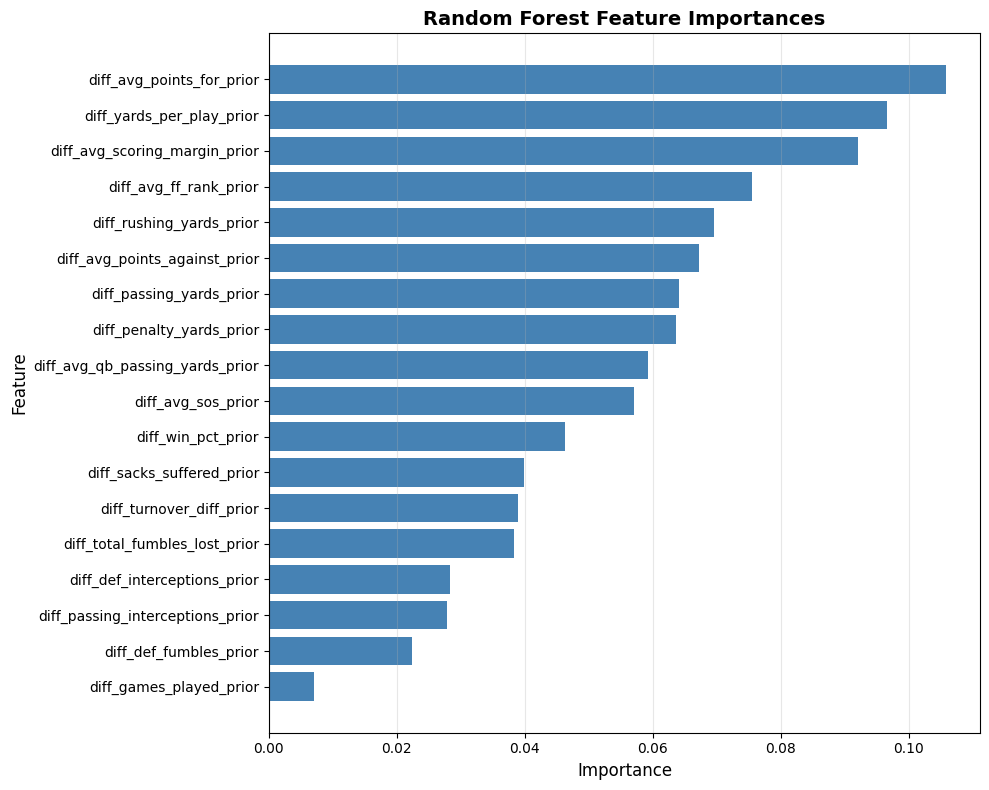

In [8]:
# ============================================================================
# STEP 7: Visualize Feature Importances
# ============================================================================

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

In [9]:
# ============================================================================
# STEP 8: Select Top 10 Features
# ============================================================================

# Select top 10 features
top_n = 10
top_features = importance_df.head(top_n)['Feature'].tolist()

print("\n" + "="*80)
print(f"TOP {top_n} FEATURES SELECTED")
print("="*80)
for i, feat in enumerate(top_features, 1):
    importance = importance_df[importance_df['Feature'] == feat]['Importance'].values[0]
    print(f"   {i:2d}. {feat:40s} → {importance:.4f}")

# Create reduced feature set
X_reduced = X[top_features]
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

# Scale the reduced features
scaler_reduced = StandardScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)

print(f"\n✓ Reduced feature matrix created: {X_reduced.shape}")


TOP 10 FEATURES SELECTED
    1. diff_avg_points_for_prior                → 0.1058
    2. diff_yards_per_play_prior                → 0.0967
    3. diff_avg_scoring_margin_prior            → 0.0921
    4. diff_avg_ff_rank_prior                   → 0.0756
    5. diff_rushing_yards_prior                 → 0.0696
    6. diff_avg_points_against_prior            → 0.0673
    7. diff_passing_yards_prior                 → 0.0640
    8. diff_penalty_yards_prior                 → 0.0637
    9. diff_avg_qb_passing_yards_prior          → 0.0592
   10. diff_avg_sos_prior                       → 0.0571

✓ Reduced feature matrix created: (1776, 10)


In [10]:
# ============================================================================
# STEP 9: Train Logistic Regression on Top Features
# ============================================================================

print("\n" + "="*80)
print("LOGISTIC REGRESSION - TRAINING ON TOP FEATURES")
print("="*80)

# Train logistic regression on reduced feature set
log_reg = LogisticRegression(
    max_iter=1000,
    random_state=42
)

print("\nTraining Logistic Regression on top 10 features...")
log_reg.fit(X_train_reduced_scaled, y_train)

print("\n✓ Logistic Regression trained successfully")


LOGISTIC REGRESSION - TRAINING ON TOP FEATURES

Training Logistic Regression on top 10 features...

✓ Logistic Regression trained successfully


In [11]:
# ============================================================================
# STEP 10: Display Model Performance
# ============================================================================

# Make predictions
y_train_pred = log_reg.predict(X_train_reduced_scaled)
y_test_pred = log_reg.predict(X_test_reduced_scaled)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n" + "="*80)
print("MODEL PERFORMANCE")
print("="*80)
print(f"\nLogistic Regression (Top {top_n} Features):")
print(f"   Training Accuracy: {train_acc:.4f}")
print(f"   Testing Accuracy:  {test_acc:.4f}")


MODEL PERFORMANCE

Logistic Regression (Top 10 Features):
   Training Accuracy: 0.6232
   Testing Accuracy:  0.6489


In [12]:
# ============================================================================
# STEP 11: Predict winner of Super Bowl LX 2026
# ============================================================================

# Super Bowl LX: Patriots vs Seahawks
# February 8, 2026 at Levi's Stadium, Santa Clara, CA
# Note: Super Bowl is played at neutral site, but we'll treat SEA as "home" for model purposes

home_team = "SEA"   # Seattle Seahawks (NFC Champion)
away_team = "NE"    # New England Patriots (AFC Champion)
season_year = 2025  # Using 2025 season data (current season)

# Team name mapping for display
team_names = {
    "SEA": "Seattle Seahawks",
    "NE": "New England Patriots"
}

print("\n" + "="*80)
print(f"SUPER BOWL LX PREDICTION: {away_team} vs {home_team}")
print("February 8, 2026 - Levi's Stadium, Santa Clara, CA")
print("="*80)

# Get latest complete data for both teams
home_all_data = team_prior_features[
    (team_prior_features['team'] == home_team) & 
    (team_prior_features['season'] == season_year)
].sort_values('week', ascending=False)

away_all_data = team_prior_features[
    (team_prior_features['team'] == away_team) & 
    (team_prior_features['season'] == season_year)
].sort_values('week', ascending=False)

if len(home_all_data) == 0 or len(away_all_data) == 0:
    print(f"\n⚠️  ERROR: One or both teams have NO data for {season_year} season!")
else:
    # Filter to rows with NO NaN values
    home_complete = home_all_data.dropna()
    away_complete = away_all_data.dropna()
    
    if len(home_complete) == 0 or len(away_complete) == 0:
        print(f"\n⚠️  ERROR: No complete data found for one or both teams!")
    else:
        # Get the latest week that exists for BOTH teams with complete data
        home_latest_week = home_complete.iloc[0]['week']
        away_latest_week = away_complete.iloc[0]['week']
        latest_common_week = min(home_latest_week, away_latest_week)
        
        # Get stats for that week
        home_stats = home_complete[home_complete['week'] == latest_common_week].head(1)
        away_stats = away_complete[away_complete['week'] == latest_common_week].head(1)
        
        if len(home_stats) == 0 or len(away_stats) == 0:
            print(f"\n⚠️  ERROR: Could not find matching week {latest_common_week} for both teams")
        else:
            print(f"\nUsing Week {int(latest_common_week)} data (latest with complete stats for both teams)")
            print(f"   {home_team}: {home_stats['games_played_prior'].values[0]:.0f} games played")
            print(f"   {away_team}: {away_stats['games_played_prior'].values[0]:.0f} games played")
            
            # Calculate difference features for top 10 features only
            diff_data = {}
            for feature in top_features:
                orig_feature = feature.replace('diff_', '')
                home_val = home_stats[orig_feature].values[0] if orig_feature in home_stats.columns else 0
                away_val = away_stats[orig_feature].values[0] if orig_feature in away_stats.columns else 0
                diff_data[feature] = [home_val - away_val]
            
            prediction_df = pd.DataFrame(diff_data)
            
            # Scale and predict
            prediction_scaled = scaler_reduced.transform(prediction_df)
            prediction_proba = log_reg.predict_proba(prediction_scaled)[0, 1]
            
            # Display results
            print("\n" + "="*80)
            print("PREDICTION RESULTS")
            print("="*80)
            
            if prediction_proba > 0.5:
                winner = home_team
                winner_name = team_names[home_team]
                confidence = prediction_proba * 100
            else:
                winner = away_team
                winner_name = team_names[away_team]
                confidence = (1 - prediction_proba) * 100
            
            print(f"\n🏆 SUPER BOWL LX CHAMPION: {winner_name}")
            print(f"   Model Confidence: {confidence:.1f}%")
            print(f"\n   Seattle Seahawks (NFC) win probability: {prediction_proba:.1%}")
            print(f"   New England Patriots (AFC) win probability: {(1-prediction_proba):.1%}")
            
            # Show key feature differences
            print(f"\n📊 Key Feature Differences (Home - Away):")
            for feat in top_features[:5]:  # Show top 5
                val = prediction_df[feat].values[0]
                direction = "↑" if val > 0 else "↓" if val < 0 else "="
                print(f"   {direction} {feat.replace('diff_', '').replace('_prior', '')}: {val:+.3f}")


SUPER BOWL LX PREDICTION: NE vs SEA
February 8, 2026 - Levi's Stadium, Santa Clara, CA

Using Week 18 data (latest with complete stats for both teams)
   SEA: 16 games played
   NE: 16 games played

PREDICTION RESULTS

🏆 SUPER BOWL LX CHAMPION: New England Patriots
   Model Confidence: 59.4%

   Seattle Seahawks (NFC) win probability: 40.6%
   New England Patriots (AFC) win probability: 59.4%

📊 Key Feature Differences (Home - Away):
   ↓ avg_points_for: -6.000
   ↓ yards_per_play: -1.502
   ↓ avg_scoring_margin: -4.000
   ↓ avg_ff_rank: -6.810
   ↓ rushing_yards: -32.000


In [13]:
# ============================================================================
# STEP 12: Save Model, Scaler, and Features for Production
# ============================================================================
import pickle
import json

print("\n" + "="*80)
print("SAVING MODEL ARTIFACTS")
print("="*80)

# Save the trained Logistic Regression model
with open('tnf_logreg_model.pkl', 'wb') as f:
    pickle.dump(log_reg, f)
print("✓ Model saved: tnf_logreg_model.pkl")

# Save the scaler
with open('tnf_scaler.pkl', 'wb') as f:
    pickle.dump(scaler_reduced, f)
print("✓ Scaler saved: tnf_scaler.pkl")

# Save the top features list
with open('tnf_features.json', 'w') as f:
    json.dump(top_features, f, indent=2)
print("✓ Features saved: tnf_features.json")

print("\n✓ All artifacts saved successfully!")
print("\nFiles created:")
print("  - tnf_logreg_model.pkl (Logistic Regression model)")
print("  - tnf_scaler.pkl (StandardScaler)")
print("  - tnf_features.json (List of 10 features)")


SAVING MODEL ARTIFACTS
✓ Model saved: tnf_logreg_model.pkl
✓ Scaler saved: tnf_scaler.pkl
✓ Features saved: tnf_features.json

✓ All artifacts saved successfully!

Files created:
  - tnf_logreg_model.pkl (Logistic Regression model)
  - tnf_scaler.pkl (StandardScaler)
  - tnf_features.json (List of 10 features)
